## Import Dependencies

In [29]:
import csv
from pathlib import Path
import pandas as pd
import glob
from datetime import datetime, timedelta
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.metrics import mean_squared_error
import seaborn as sns
import pandas_profiling as pp

# Get the Single-Family Loan Performance Data Files from Fannie Mae

From the Fannie Mae [website:](https://loanperformancedata.fanniemae.com/lppub/index.html#Single-Family_Loan_Performance_Data_Files) we downloaded the Acquisition dataset (998MB zip file)

The [Acquisition file layout](https://loanperformancedata.fanniemae.com/lppub-docs/FNMA_SF_Loan_Performance_File_layout.pdf) was as follows:
![Acquisition File Layout](images/AcquisitionFileLayoutMedium.jpg)

In [2]:
# Create mapping for the header of the files based on above file format
headerline = ['loanIdentifier','origChannel','sellerName','origIntRate','origUPB','origLoanTerm',\
         'origDate','firstPmtDate','origLTV','origCLTV','numBorrowers','origDebtIncRatio',\
         'borrCreditScore','firstTHBI','loanPurp','propType','numUnits','occType','propState',\
         'zipCode','pMIperct','prodType','coborrCreditScore','mortInsType','relocMortInd']

In [3]:
# Loop through each file from the unzipped downloade file - which gave a set of 76 individual files

#Create an empty array to hold dataframes to later concatonate
li = []

#Loop through every file in the directory and append into array
for in_path in Path('D:\Acquisition_All').glob('*.txt'):
    df = pd.read_csv(in_path, sep="|", index_col=None, header=None)
    li.append(df)

#Concatonate all the array elements into one giant dataframe
df = pd.concat(li, axis=0, ignore_index=True)
df.columns = headerline

In [4]:
df.shape

(40887332, 25)

In [5]:
#Review the columns for datatypes and how many non-null values 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40887332 entries, 0 to 40887331
Data columns (total 25 columns):
loanIdentifier       int64
origChannel          object
sellerName           object
origIntRate          float64
origUPB              int64
origLoanTerm         int64
origDate             object
firstPmtDate         object
origLTV              float64
origCLTV             float64
numBorrowers         float64
origDebtIncRatio     float64
borrCreditScore      float64
firstTHBI            object
loanPurp             object
propType             object
numUnits             int64
occType              object
propState            object
zipCode              int64
pMIperct             float64
prodType             object
coborrCreditScore    float64
mortInsType          float64
relocMortInd         object
dtypes: float64(9), int64(5), object(11)
memory usage: 7.6+ GB


### Convert the origDate,firstPmtDate columns from strings to datetime datatypes
Test fastest way to change datatypes

`%timeit df['origDate'] = pd.to_datetime(df['origDate'], format='%m/%Y')`  
5.43 ms ± 457 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)

`%timeit df['origDate'] = pd.to_datetime(df['origDate'], format='%m/%Y')`  
5.48 ms ± 91.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

Not much difference in speeds so I'll choose the `to_datetime` method

In [6]:
df['origDate'] = pd.to_datetime(df['origDate'], format='%m/%Y')
df['firstPmtDate'] = pd.to_datetime(df['firstPmtDate'], format='%m/%Y')

### Filter out records with values we aren't interested in examining:

Using the [Glossary](https://loanperformancedata.fanniemae.com/lppub-docs/FNMA_SF_Loan_Performance_Glossary.pdf) of column names we made the following selections:
![Property Type](images/propertyType.jpg)
* Property type: only want 'SF' - 'Single Family'

In [7]:
propTypeFilter = ['SF']
df = df[df.propType.isin(propTypeFilter)]
df.shape

(30093769, 25)

![Number of Units](images/numUnits.jpg)
* Number of Units: only want '1'

In [8]:
numUnitsFilter = [1]
df = df[df.numUnits.isin(numUnitsFilter)]
df.shape

(29072952, 25)

![Number of Units](images/occType.jpg)
* Number of Units: only want 'P'

In [9]:
occTypeFilter = ['P']
df = df[df.occType.isin(occTypeFilter)]
df.shape

(26581922, 25)

![Number of Units](images/loanPurp.jpg)
* Number of Units: only want 'C,R,U'

In [10]:
loanPurpFilter = ['C','R','U']
df = df[df.loanPurp.isin(loanPurpFilter)]
df.shape

(18724184, 25)

![Number of Units](images/origLoanTerm.jpg)
* Number of Units: only want '360'

In [11]:
origLoanTermFilter = [360]
df = df[df.origLoanTerm.isin(origLoanTermFilter)]
df.shape

(10715674, 25)

### Fill null values with 0 for the following columns
We can't have NaN or Null values for the machine learning part to come

In [12]:
df['mortInsType'] = df['mortInsType'].fillna(0)
df['pMIperct'] = df['pMIperct'].fillna(0)
df['origCLTV'] = df['origCLTV'].fillna(0)

## Calculate the 'Best', 'Worst' and 'Avg' Credit Score
Given that there is a Borrower Credit Score and a Co-Borrower Credit Score and that there are Null values for each we want to create calculated columns where no Null values exist and then drop the original columns

In [13]:
df['bestCreditScore'] = df[['borrCreditScore','coborrCreditScore']].max(axis=1)
df['worstCreditScore'] = df[['borrCreditScore','coborrCreditScore']].min(axis=1)
df['avgCreditScore'] = df[['borrCreditScore','coborrCreditScore']].mean(axis=1)

### Get rid of records where there are NaN or NULL values for:
* 'Borrower Credit Score'
* 'Debt to Income Ratio'
* 'Number of Borrowers'

In [14]:
df = df[df['borrCreditScore'].notna() &\
        df['origDebtIncRatio'].notna() &\
        df['numBorrowers'].notna()]

### Drop all columns where there is only a single value (and coborrower Credit Score)

In [15]:
df = df.drop(['prodType','firstTHBI','relocMortInd','occType','numUnits','origLoanTerm','coborrCreditScore','propType'], axis=1)

### Map text values to integers (Machine Learning will require this later)

![OrigChannel](images/origChannel.jpg)

In [16]:
df['origChannel'] = df['origChannel'].replace(['R','B','C'],[1,2,3])
df['origChannel'] = pd.to_numeric(df['origChannel'])

![Loan Purpose](images/loanPurp.jpg)

In [17]:
df['loanPurp'] = df['loanPurp'].replace(['C','R','U'],[1,2,3])
df['loanPurp'] = pd.to_numeric(df['loanPurp'])

In [18]:
df['loanPurp'].unique()

array([2, 1, 3], dtype=int64)

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10464607 entries, 0 to 40887331
Data columns (total 20 columns):
loanIdentifier      int64
origChannel         int64
sellerName          object
origIntRate         float64
origUPB             int64
origDate            datetime64[ns]
firstPmtDate        datetime64[ns]
origLTV             float64
origCLTV            float64
numBorrowers        float64
origDebtIncRatio    float64
borrCreditScore     float64
loanPurp            int64
propState           object
zipCode             int64
pMIperct            float64
mortInsType         float64
bestCreditScore     float64
worstCreditScore    float64
avgCreditScore      float64
dtypes: datetime64[ns](2), float64(11), int64(5), object(2)
memory usage: 1.6+ GB


In [20]:
df.head()

,loanIdentifier,origChannel,sellerName,origIntRate,origUPB,origDate,firstPmtDate,origLTV,origCLTV,numBorrowers,origDebtIncRatio,borrCreditScore,loanPurp,propState,zipCode,pMIperct,mortInsType,bestCreditScore,worstCreditScore,avgCreditScore
0,100007365142,1,"JPMORGAN CHASE BANK, NA",8.000,75000,1999-12-01,2000-02-01,79.0,0.0,1.0,62.0,763.0,2,PA,173,0.0,0.0,763.0,763.0,763.0
25,100094030068,3,"CITIMORTGAGE, INC.",7.750,152000,1999-11-01,2000-01-01,85.0,0.0,1.0,41.0,604.0,2,NV,891,25.0,1.0,604.0,604.0,604.0
30,100118647578,2,"JPMORGAN CHASE BANK, NA",7.750,106000,1999-11-01,2000-01-01,80.0,0.0,2.0,27.0,652.0,2,OR,972,0.0,0.0,696.0,652.0,674.0
32,100122555751,1,"GMAC MORTGAGE, LLC",8.250,191000,2000-02-01,2000-04-01,78.0,0.0,1.0,52.0,676.0,1,CA,921,0.0,0.0,676.0,676.0,676.0
34,100123116925,3,"BANK OF AMERICA, N.A.",7.875,240000,1999-12-01,2000-02-01,74.0,0.0,3.0,40.0,718.0,2,CA,940,0.0,0.0,718.0,685.0,701.5


In [21]:
# Check if updated files from Fannie Mae have created duplicate entries for a given loan Identifier 
#(number should equal the number of records if there are no duplicates)
df.groupby('loanIdentifier').loanIdentifier.nunique().sum()

10464607

In [26]:
sellerNames = df['sellerName'].unique()
statesList = df['propState'].unique()

In [27]:
corr = df.corr()

Text(0.5, 1, 'Pearson Correlation matrix for Fannie 2019 Q1 avg Fico scores dataset')

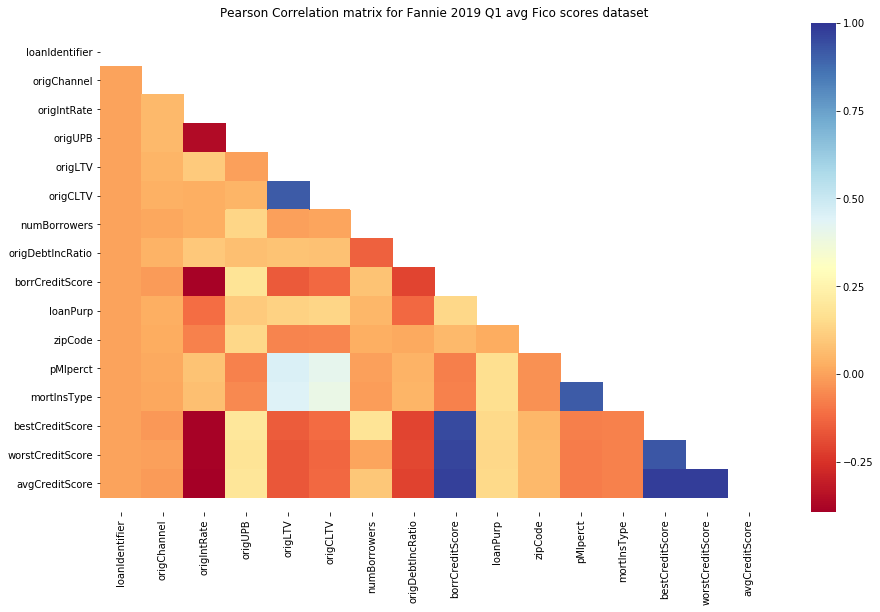

In [30]:
# Plot the Pearson Correlation reduced matrix
matrix = np.triu(corr)
fig, ax = plt.subplots(figsize=(15,9)) 
ax = sns.heatmap(corr,   mask = matrix, cmap = 'RdYlBu')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Pearson Correlation matrix for Fannie 2019 Q1 avg Fico scores dataset')

## Get Freddie Mac 30 yr weekly rate

In [31]:
# import training_data via pandas module
fmac30 = pd.read_csv("data/FMAC-30US.csv", low_memory=False)

In [32]:
fmac30.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2565 entries, 0 to 2564
Data columns (total 2 columns):
Date     2565 non-null object
Value    2565 non-null float64
dtypes: float64(1), object(1)
memory usage: 40.2+ KB


In [33]:
fmac30.head()

,Date,Value
0,4/2/1971,7.33
1,4/9/1971,7.31
2,4/16/1971,7.31
3,4/23/1971,7.31
4,4/30/1971,7.29


In [34]:
fmac30['Date'] = pd.to_datetime(fmac30['Date'])

In [35]:
#fmac30 = fmac30[(fmac30['Date'] > '12/28/1999') & (fmac30['Date'] < '4/1/2019')]

In [36]:
fmac30.head()

,Date,Value
0,1971-04-02,7.33
1,1971-04-09,7.31
2,1971-04-16,7.31
3,1971-04-23,7.31
4,1971-04-30,7.29


In [37]:
fmac30 = fmac30.set_index('Date').resample('D').ffill().reset_index()

In [38]:
fmac30 = fmac30.rename(columns={'Date':'origDate','Value':'fmacRate'})

In [39]:
fmac30.head()

,origDate,fmacRate
0,1971-04-02,7.33
1,1971-04-03,7.33
2,1971-04-04,7.33
3,1971-04-05,7.33
4,1971-04-06,7.33


## Get 10 yr Treasury daily rate

In [40]:
# import training_data via pandas module
fred10 = pd.read_csv("data/FRED-DGS10.csv", low_memory=False)

In [41]:
fred10.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14575 entries, 0 to 14574
Data columns (total 2 columns):
Date     14575 non-null object
Value    14575 non-null float64
dtypes: float64(1), object(1)
memory usage: 227.8+ KB


In [42]:
fred10.head()

,Date,Value
0,1/2/1962,4.06
1,1/3/1962,4.03
2,1/4/1962,3.99
3,1/5/1962,4.02
4,1/8/1962,4.03


In [43]:
fred10['Date'] = pd.to_datetime(fred10['Date'])

In [44]:
#fred10 = fred10[(fred10['Date'] > '12/28/1999') & (fred10['Date'] < '4/1/2019')]

In [45]:
fred10 = fred10.set_index('Date').resample('D').ffill().reset_index()

In [46]:
fred10 = fred10.rename(columns={'Date':'origDate','Value':'fredRate'})

In [47]:
fred10.head()

,origDate,fredRate
0,1962-01-02,4.06
1,1962-01-03,4.03
2,1962-01-04,3.99
3,1962-01-05,4.02
4,1962-01-06,4.02


## Merge data

In [48]:
# Merge data
merged = pd.merge(df, fmac30, on=["origDate"])
merged.shape

(10464607, 21)

In [49]:
# Merge data
merged = pd.merge(merged, fred10, on=["origDate"])
merged.shape

(10464607, 22)

In [50]:
merged['rateDiff'] = merged['origIntRate'] - merged['fmacRate']

In [51]:
merged['rateDiffPct'] = merged['rateDiff'] / merged['fmacRate']

In [52]:
merged.shape

(10464607, 24)

In [53]:
merged.head()

,loanIdentifier,origChannel,sellerName,origIntRate,origUPB,origDate,firstPmtDate,origLTV,origCLTV,numBorrowers,...,zipCode,pMIperct,mortInsType,bestCreditScore,worstCreditScore,avgCreditScore,fmacRate,fredRate,rateDiff,rateDiffPct
0,100007365142,1,"JPMORGAN CHASE BANK, NA",8.000,75000,1999-12-01,2000-02-01,79.0,0.0,1.0,...,173,0.0,0.0,763.0,763.0,763.0,7.75,6.21,0.250,0.032258
1,100123116925,3,"BANK OF AMERICA, N.A.",7.875,240000,1999-12-01,2000-02-01,74.0,0.0,3.0,...,940,0.0,0.0,718.0,685.0,701.5,7.75,6.21,0.125,0.016129
2,100132383737,3,"BANK OF AMERICA, N.A.",7.625,165000,1999-12-01,2000-02-01,80.0,0.0,2.0,...,370,0.0,0.0,745.0,646.0,695.5,7.75,6.21,-0.125,-0.016129
3,100206168296,3,SUNTRUST MORTGAGE INC.,7.750,221000,1999-12-01,2000-02-01,90.0,0.0,2.0,...,255,17.0,1.0,745.0,644.0,694.5,7.75,6.21,0.000,0.000000
4,100272527248,2,"JPMORGAN CHASE BANK, NATIONAL ASSOCIATION",7.750,129000,1999-12-01,2000-02-01,77.0,0.0,1.0,...,178,0.0,0.0,637.0,637.0,637.0,7.75,6.21,0.000,0.000000


In [54]:
# Save the data prior to the binning steps
#merged.to_csv('data/FannieAcq2000-19FMac30.csv')

## Create Classes for the rateDiffPct field
#### rateDiffPct is the difference between the origination Interest Rate for the loan and the Freddie Mac 30 year Mortgage rate for the week of the origination of the loan. We want to bin rates by what % the differed from the published FMAC rate.

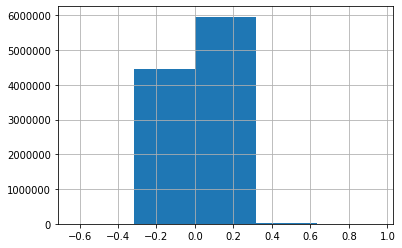

In [55]:
merged['rateDiffPct'].hist(bins=5)

In [56]:
bin_width = (merged['rateDiffPct'].max() - merged['rateDiffPct'].min())/5

In [57]:
bin_width

0.316378845116028

In [58]:
merged['rateDiffPct'].describe()

count    1.046460e+07
mean     1.801125e-02
std      7.267237e-02
min     -6.323529e-01
25%     -2.542373e-02
50%      1.180438e-02
75%      5.240550e-02
max      9.495413e-01
Name: rateDiffPct, dtype: float64

In [59]:
merged['rateDiffPct'].value_counts(bins=7, sort=False)

(-0.635, -0.406]          3
(-0.406, -0.18]       35342
(-0.18, 0.0456]     7533966
(0.0456, 0.272]     2824022
(0.272, 0.498]        70647
(0.498, 0.724]          619
(0.724, 0.95]             6
Name: rateDiffPct, dtype: int64

In [60]:
merged['rank'] = pd.cut(merged['rateDiffPct'], 9, labels=[0,1,2,3,4,5,6,7,8])

In [61]:
merged['rank'] = pd.to_numeric(merged['rank'])

In [62]:
merged['rank'].value_counts()

3.0    8284665
4.0    1767730
2.0     301528
5.0     107053
6.0       3397
1.0        170
7.0         56
8.0          3
0.0          3
Name: rank, dtype: int64

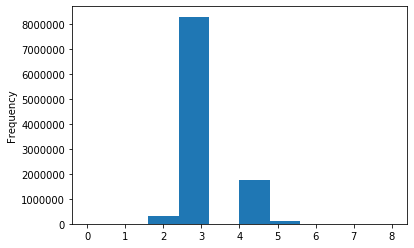

In [63]:
merged['rank'].plot(kind='hist')

In [64]:
merged.head()

,loanIdentifier,origChannel,sellerName,origIntRate,origUPB,origDate,firstPmtDate,origLTV,origCLTV,numBorrowers,...,pMIperct,mortInsType,bestCreditScore,worstCreditScore,avgCreditScore,fmacRate,fredRate,rateDiff,rateDiffPct,rank
0,100007365142,1,"JPMORGAN CHASE BANK, NA",8.000,75000,1999-12-01,2000-02-01,79.0,0.0,1.0,...,0.0,0.0,763.0,763.0,763.0,7.75,6.21,0.250,0.032258,3.0
1,100123116925,3,"BANK OF AMERICA, N.A.",7.875,240000,1999-12-01,2000-02-01,74.0,0.0,3.0,...,0.0,0.0,718.0,685.0,701.5,7.75,6.21,0.125,0.016129,3.0
2,100132383737,3,"BANK OF AMERICA, N.A.",7.625,165000,1999-12-01,2000-02-01,80.0,0.0,2.0,...,0.0,0.0,745.0,646.0,695.5,7.75,6.21,-0.125,-0.016129,3.0
3,100206168296,3,SUNTRUST MORTGAGE INC.,7.750,221000,1999-12-01,2000-02-01,90.0,0.0,2.0,...,17.0,1.0,745.0,644.0,694.5,7.75,6.21,0.000,0.000000,3.0
4,100272527248,2,"JPMORGAN CHASE BANK, NATIONAL ASSOCIATION",7.750,129000,1999-12-01,2000-02-01,77.0,0.0,1.0,...,0.0,0.0,637.0,637.0,637.0,7.75,6.21,0.000,0.000000,3.0


In [65]:
#merged.to_csv('data/FannieAcq2019Q1FMac30bin9.csv')

In [ ]:
pp.ProfileReport(merged)